<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/%EC%85%80%ED%8A%B8%EB%A6%AC%EC%98%A8_%ED%86%B5%ED%95%A9%ED%85%8C%EC%9D%B4%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘 시작

## 라이브러리 설치

In [1]:
!pip install finance-datareader
!pip install pykrx
!pip install pymysql
!pip install konlpy
from konlpy.tag import Okt
okt = Okt()

     |████████████████████████████████| 70 kB 3.7 MB/s 
     |████████████████████████████████| 60 kB 7.3 MB/s 
     |████████████████████████████████| 251 kB 38.8 MB/s 
     |████████████████████████████████| 43 kB 1.1 MB/s 
     |████████████████████████████████| 19.4 MB 37.2 MB/s 
     |████████████████████████████████| 448 kB 28.5 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


## 패키지 & 함수 로딩

In [2]:
# 필요 라이브러리
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 주식가격 로딩
import FinanceDataReader as fdr
from pykrx import stock

import datetime

In [3]:
def money_sur(stock_name, start, end):

    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')

    return data

In [4]:
def reverse_min_max_scaling(org_x, x): #종가 예측값
    org_x_np = np.asarray(org_x) 
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min())) + org_x_np.min()

## 통합테이블 생성

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# total_table = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/total_table.csv') # 기존 테이블

In [7]:
# 구성
dic = {'code' : [],
       'date' : [],
       'lstm' : [],
       'arima' : [],
       'fbprophet' : [],
       'RL' : [],
    #    'mail_news' : [],
    #    'mail_news_nsi' : [],
    #    'asia_news' : [],
    #    'asia_news_nsi': [],
    #    'youtube_sam' : [],
    #    'youtube_su' : [],
    #    'youtube_han' : [],
       'close' : []}

total_table = pd.DataFrame(dic)

In [8]:
total_table.columns

Index(['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'close'], dtype='object')

In [9]:
total_table

,code,date,lstm,arima,fbprophet,RL,close


## LSTM 예측결과

### 사용 데이터 로드 및 전처리

In [10]:
# start_date = (datetime.datetime.now() - datetime.timedelta(40)).strftime("%Y%m%d")
end_date = datetime.datetime.now().strftime("%Y%m%d")
lstm = money_sur('068270', '2018', end_date)

In [11]:
lstm = lstm.set_index('Date')

In [12]:
lstm.head()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
Date,,,,,,,,,,,,
2018-01-02,206047,209825,204757,208167,1176443,0.021709,16457,150.10,13.730000,1505,0.0,0
2018-01-03,210931,227794,209272,227334,2411162,0.092075,16457,163.92,14.990000,1505,0.0,0
2018-01-04,230007,240696,226044,230376,3265527,0.013381,16457,166.11,15.190000,1505,0.0,0
2018-01-05,234890,246041,234061,245949,1920918,0.067598,16457,177.34,16.219999,1505,0.0,0
2018-01-08,256637,279399,255440,278754,4298770,0.133381,16457,201.00,18.379999,1505,0.0,0


In [13]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
lstm_sc = sc.fit_transform(lstm)

In [14]:
scale_cols = lstm.columns
lstm_sc_df = pd.DataFrame(lstm_sc, columns=[scale_cols], index=lstm.index)

In [15]:
lstm_sc_df.head()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
Date,,,,,,,,,,,,
2018-01-02,0.294738,0.275843,0.308048,0.286302,0.090132,0.420890,0.0,0.486603,0.423052,0.0,0.0,0.0
2018-01-03,0.313528,0.345646,0.326399,0.359037,0.202977,0.609431,0.0,0.559069,0.504185,0.0,0.0,0.0
2018-01-04,0.386917,0.395766,0.394569,0.370580,0.281060,0.398577,0.0,0.570552,0.517064,0.0,0.0,0.0
2018-01-05,0.405703,0.416530,0.427154,0.429677,0.158172,0.543847,0.0,0.629437,0.583387,0.0,0.0,0.0
2018-01-08,0.489368,0.546115,0.514049,0.554165,0.375491,0.720107,0.0,0.753500,0.722473,0.0,0.0,0.0


In [16]:
for i in scale_cols:
  for s in range(1, 11):  
    lstm_sc_df[(i+'shift_{}'.format(s),)] = lstm_sc_df[(i,)].shift(s)

In [17]:
lstm_sc_df.dropna()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,Lowshift_5,Lowshift_6,Lowshift_7,Lowshift_8,...,PBRshift_1,PBRshift_2,PBRshift_3,PBRshift_4,PBRshift_5,PBRshift_6,PBRshift_7,PBRshift_8,PBRshift_9,PBRshift_10,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-16,0.710948,0.715079,0.731284,0.711178,0.133378,0.342819,0.0,0.909916,0.898261,0.0,0.0,0.0,0.719812,0.652801,0.560634,0.577288,0.579774,0.489368,0.405703,0.386917,0.313528,0.294738,0.735485,0.799555,0.559723,0.588353,0.606254,0.546115,0.416530,0.395766,0.345646,0.275843,0.706190,0.664988,0.573228,0.543260,0.566485,0.514049,0.427154,0.394569,...,0.908564,0.875080,0.739858,0.697360,0.683194,0.722473,0.583387,0.517064,0.504185,0.423052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-17,0.733635,0.704699,0.646263,0.592633,0.300973,0.101261,0.0,0.791831,0.765615,0.0,0.0,0.0,0.710948,0.719812,0.652801,0.560634,0.577288,0.579774,0.489368,0.405703,0.386917,0.313528,0.715079,0.735485,0.799555,0.559723,0.588353,0.606254,0.546115,0.416530,0.395766,0.345646,0.731284,0.706190,0.664988,0.573228,0.543260,0.566485,0.514049,0.427154,...,0.898261,0.908564,0.875080,0.739858,0.697360,0.683194,0.722473,0.583387,0.517064,0.504185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-18,0.597148,0.618428,0.620421,0.612916,0.161207,0.412297,0.0,0.812018,0.788152,0.0,0.0,0.0,0.733635,0.710948,0.719812,0.652801,0.560634,0.577288,0.579774,0.489368,0.405703,0.386917,0.704699,0.715079,0.735485,0.799555,0.559723,0.588353,0.606254,0.546115,0.416530,0.395766,0.646263,0.731284,0.706190,0.664988,0.573228,0.543260,0.566485,0.514049,...,0.765615,0.898261,0.908564,0.875080,0.739858,0.697360,0.683194,0.722473,0.583387,0.517064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-19,0.636497,0.609117,0.541013,0.502761,0.325846,0.098385,0.0,0.702270,0.665164,0.0,0.0,0.0,0.597148,0.733635,0.710948,0.719812,0.652801,0.560634,0.577288,0.579774,0.489368,0.405703,0.618428,0.704699,0.715079,0.735485,0.799555,0.559723,0.588353,0.606254,0.546115,0.416530,0.620421,0.646263,0.731284,0.706190,0.664988,0.573228,0.543260,0.566485,...,0.788152,0.765615,0.898261,0.908564,0.875080,0.739858,0.697360,0.683194,0.722473,0.583387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-22,0.498232,0.498501,0.488951,0.477582,0.236516,0.295690,0.0,0.677206,0.636832,0.0,0.0,0.0,0.636497,0.597148,0.733635,0.710948,0.719812,0.652801,0.560634,0.577288,0.579774,0.489368,0.609117,0.618428,0.704699,0.715079,0.735485,0.799555,0.559723,0.588353,0.606254,0.546115,0.541013,0.620421,0.646263,0.731284,0.706190,0.664988,0.573228,0.543260,...,0.665164,0.788152,0.765615,0.898261,0.908564,0.875080,0.739858,0.697360,0.683194,0.722473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [18]:
X_test = lstm_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_test = lstm_sc_df.dropna()[['Close']]

X_test= X_test.values
y_test = y_test.values

In [19]:
X_test

array([[0.71981195, 0.65280134, 0.56063387, ..., 0.        , 0.        ,
        0.        ],
       [0.71094799, 0.71981195, 0.65280134, ..., 0.        , 0.        ,
        0.        ],
       [0.73363495, 0.71094799, 0.71981195, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.5003828 , 0.52154242, 0.54847285, ..., 0.        , 0.        ,
        0.        ],
       [0.5023064 , 0.5003828 , 0.52154242, ..., 0.        , 0.        ,
        0.        ],
       [0.49461199, 0.5023064 , 0.5003828 , ..., 0.        , 0.        ,
        0.        ]])

In [20]:
X_test_t = X_test.reshape(X_test.shape[0], 10, 12)

### 모델 로드

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(LSTM(64,
               input_shape = (12, 12),
               return_sequences= True))
model.add(LSTM(64,
               return_sequences = False))
model.add(Dense(32, activation = 'tanh'))
model.add(Dense(1))

lstm_path = '/content/drive/My Drive/Final PJT - 업빛투/Regression/LSTM/'
cel_lstm = 'lstm_cel.h5'

model.load_weights(lstm_path+cel_lstm)

### 모델 결과

In [22]:
pred = model.predict(X_test_t)

In [23]:
pred.shape, y_test.shape

((915, 1), (915, 1))

In [24]:
pred_act = reverse_min_max_scaling(lstm['Close'], pred)

In [25]:
total_table['date'] = lstm.index[10:]
total_table['lstm'] = pred_act[:]
total_table['close'] = lstm.Close[10:].values.reshape(-1,1)
total_table['code'] = '068270'
total_table['change'] = lstm.Change[10:].values.reshape(-1,1)

In [26]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,068270,2018-01-16,295774.113194,NaN,NaN,NaN,320130,-0.007429
1,068270,2018-01-17,293455.358051,NaN,NaN,NaN,288891,-0.097582
2,068270,2018-01-18,290358.197563,NaN,NaN,NaN,294236,0.018502
3,068270,2018-01-19,287564.888146,NaN,NaN,NaN,265208,-0.098656
4,068270,2018-01-22,275099.219279,NaN,NaN,NaN,258573,-0.025018
...,...,...,...,...,...,...,...,...
910,068270,2021-09-28,263795.928013,NaN,NaN,NaN,263500,-0.014953
911,068270,2021-09-29,255644.198278,NaN,NaN,NaN,261000,-0.009488
912,068270,2021-09-30,249901.648635,NaN,NaN,NaN,259500,-0.005747
913,068270,2021-10-01,252360.988892,NaN,NaN,NaN,248000,-0.044316


## arima 예측결과

In [27]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
samsung_df = money_sur('068270', '2000', end_date)

In [28]:
df = samsung_df[['Date','Close']]
df.columns = ['Date', 'Price']

In [29]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
# 학습, 테스트 데이터 분리
for ru in range(-len(total_table),0):
    rus = ru+1
    train = df[:ru]
    test = df[ru:]

    model = ARIMA(train.Price.values, order = (3,1,2))
    model_fit = model.fit(trend = 'nc', full_output = True, disp = True)

    fore = model_fit.forecast(steps=1) # 오늘 예측

    # 오늘 예측 데이터
    pred_arima_y = fore[0].tolist()

    # # 신뢰구간
    # # 예측 데이터 최소값
    # pred_y_lower = []
    # # 예측 데이터 최대값
    # pred_y_upper = []

    # for lower_upper in fore[2]:
    #     lower = lower_upper[0]
    #     upper = lower_upper[1]
    #     pred_y_lower.append(lower)
    #     pred_y_upper.append(upper)
    if rus == 0:
        total_table['arima'].iloc[ru:] = pred_arima_y
    else:
        total_table['arima'].iloc[ru:rus] = pred_arima_y

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 4008
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -38964.270
Method:                       css-mle   S.D. of innovations           4034.482
Date:                Tue, 05 Oct 2021   AIC                          77940.540
Time:                        05:40:02   BIC                          77978.316
Sample:                             1   HQIC                         77953.929
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y      1.4775      0.020     75.439      0.000       1.439       1.516
ar.L2.D.y     -0.8181      0.028    -29.275      0.000      -0.873      -0.763
ar.L3.D.y     -0.0894      0.016     -5.537      0.0

In [30]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,068270,2018-01-16,295774.113194,328971.692638,NaN,NaN,320130,-0.007429
1,068270,2018-01-17,293455.358051,326105.495374,NaN,NaN,288891,-0.097582
2,068270,2018-01-18,290358.197563,287817.126024,NaN,NaN,294236,0.018502
3,068270,2018-01-19,287564.888146,293563.833290,NaN,NaN,265208,-0.098656
4,068270,2018-01-22,275099.219279,265906.239602,NaN,NaN,258573,-0.025018
...,...,...,...,...,...,...,...,...
910,068270,2021-09-28,263795.928013,268459.308890,NaN,NaN,263500,-0.014953
911,068270,2021-09-29,255644.198278,263787.250590,NaN,NaN,261000,-0.009488
912,068270,2021-09-30,249901.648635,260767.919838,NaN,NaN,259500,-0.005747
913,068270,2021-10-01,252360.988892,258977.120088,NaN,NaN,248000,-0.044316


## fbprophet 예측

In [31]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
samsung_df = money_sur('068270', start = '20180101', end = end_date)
df1 = samsung_df[['Date','Close']]
df1.columns = ['ds', 'y']

from fbprophet import Prophet

prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.6)

prophet.fit(df1)

# 10일단위로 예측값을 가져옴
future_data = prophet.make_future_dataframe(periods = 10, freq = 'd')
forecast_data = prophet.predict(future_data)

In [32]:
list(total_table.date.values)

[numpy.datetime64('2018-01-16T00:00:00.000000000'),
 numpy.datetime64('2018-01-17T00:00:00.000000000'),
 numpy.datetime64('2018-01-18T00:00:00.000000000'),
 numpy.datetime64('2018-01-19T00:00:00.000000000'),
 numpy.datetime64('2018-01-22T00:00:00.000000000'),
 numpy.datetime64('2018-01-23T00:00:00.000000000'),
 numpy.datetime64('2018-01-24T00:00:00.000000000'),
 numpy.datetime64('2018-01-25T00:00:00.000000000'),
 numpy.datetime64('2018-01-26T00:00:00.000000000'),
 numpy.datetime64('2018-01-29T00:00:00.000000000'),
 numpy.datetime64('2018-01-30T00:00:00.000000000'),
 numpy.datetime64('2018-01-31T00:00:00.000000000'),
 numpy.datetime64('2018-02-01T00:00:00.000000000'),
 numpy.datetime64('2018-02-02T00:00:00.000000000'),
 numpy.datetime64('2018-02-05T00:00:00.000000000'),
 numpy.datetime64('2018-02-06T00:00:00.000000000'),
 numpy.datetime64('2018-02-07T00:00:00.000000000'),
 numpy.datetime64('2018-02-08T00:00:00.000000000'),
 numpy.datetime64('2018-02-09T00:00:00.000000000'),
 numpy.datet

In [33]:
total_table['fbprophet'] = forecast_data[forecast_data['ds'].isin(list(total_table.date.values))]['yhat'].values

In [34]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,068270,2018-01-16,295774.113194,328971.692638,273431.621427,NaN,320130,-0.007429
1,068270,2018-01-17,293455.358051,326105.495374,273653.741065,NaN,288891,-0.097582
2,068270,2018-01-18,290358.197563,287817.126024,274844.961727,NaN,294236,0.018502
3,068270,2018-01-19,287564.888146,293563.833290,276319.076508,NaN,265208,-0.098656
4,068270,2018-01-22,275099.219279,265906.239602,278206.600060,NaN,258573,-0.025018
...,...,...,...,...,...,...,...,...
910,068270,2021-09-28,263795.928013,268459.308890,265979.647538,NaN,263500,-0.014953
911,068270,2021-09-29,255644.198278,263787.250590,264758.739050,NaN,261000,-0.009488
912,068270,2021-09-30,249901.648635,260767.919838,264500.209272,NaN,259500,-0.005747
913,068270,2021-10-01,252360.988892,258977.120088,264551.237612,NaN,248000,-0.044316


In [35]:
# total_table.to_csv('./total_table.csv', index =False)

## RL 결과

### 데이터 로딩 및 함수 로딩

In [54]:
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

# 금융정보 조회하기
def dataset_loaderKR(stock_name, start, end, train_ratio=0.7):
    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')
    date_split = data.index[int(train_ratio*len(data))] 

    return data[:date_split], data[date_split:], date_split


# ENV 설정
class Environment1:
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs

    def step(self, act):
        reward = 0
        
        # action
        # 0: Idle
        # 1: 매수
        # 2: 매도
        if act == 1: #매수
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # 매도
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

# MODEL
class Q_Network(nn.Module):
    def __init__(self,obs_len,hidden_size,actions_n):
        super(Q_Network,self).__init__()
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
    def forward(self,x):
        h = self.fc_val(x)
        return (h)

In [55]:
(train, test, date_split) = dataset_loaderKR('068270', start = '2000', end = end_date)

### 모델 로딩 및 결과

In [56]:
rl_path = '/content/drive/My Drive/Final PJT - 업빛투/Regression/RL/셀트리온_결과/'
cel_rl = 'celltrion_rl.h5'

In [57]:
# 모델 로딩
model = torch.load(rl_path+cel_rl)

test_env = Environment1(test)
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
            
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs

# sell remaining stocks
profits = 0
for p in test_env.positions:
	profits += (test_env.data.iloc[test_env.t, :]['Close'] - p)

test_env.profits += profits
test_env.positions = []

test_profits = test_env.profits
pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
pact = np.argmax(pact.data)
next_action = pact.item()
test['Action'] = test_acts + [next_action]


print( )
print( test )
print( )
print("결과")
print( "손익결과 $%.2f" % round(test_profits,2) )
# 0: Idle
# 1: 매수
# 2: 매도


           Date    Open    High     Low   Close  ...    PBR   EPS  DIV  DPS  Action
2807 2016-11-11   91866   91951   90057   90062  ...   6.94  1409  0.0    0       2
2808 2016-11-14   90489   91091   89369   89460  ...   6.89  1409  0.0    0       2
2809 2016-11-15   89114   90148   88598   88599  ...   6.83  1409  0.0    0       2
2810 2016-11-16   88945   91355   88687   90495  ...   6.97  1409  0.0    0       2
2811 2016-11-17   90832   91264   89455   89460  ...   6.89  1409  0.0    0       2
...         ...     ...     ...     ...     ...  ...    ...   ...  ...  ...     ...
4005 2021-09-28  265000  269500  263000  263500  ...  10.86  3756  0.0    0       0
4006 2021-09-29  259500  265000  259500  261000  ...  10.76  3756  0.0    0       2
4007 2021-09-30  260000  263000  259000  259500  ...  10.70  3756  0.0    0       0
4008 2021-10-01  258000  258500  247500  248000  ...  10.22  3756  0.0    0       2
4009 2021-10-05  240000  240500  218000  219500  ...   9.19  3756  0.0    0

In [58]:
test['Action'] = np.where(test['Action'] == 1,1,
                          np.where(test['Action'] == 2,-1,0))

In [59]:
test['Action'][-10:]

4000    0
4001   -1
4002   -1
4003    0
4004    0
4005    0
4006   -1
4007    0
4008   -1
4009    1
Name: Action, dtype: int64

In [60]:
test

,Date,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS,Action
2807,2016-11-11,91866,91951,90057,90062,538977,-0.019691,15069,74.24,6.94,1409,0.0,0,-1
2808,2016-11-14,90489,91091,89369,89460,356463,-0.006684,15069,73.74,6.89,1409,0.0,0,-1
2809,2016-11-15,89114,90148,88598,88599,322784,-0.009624,15069,73.03,6.83,1409,0.0,0,-1
2810,2016-11-16,88945,91355,88687,90495,458986,0.021400,15069,74.59,6.97,1409,0.0,0,-1
2811,2016-11-17,90832,91264,89455,89460,233796,-0.011437,15069,73.74,6.89,1409,0.0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4005,2021-09-28,265000,269500,263000,263500,515609,-0.014953,24262,70.15,10.86,3756,0.0,0,0
4006,2021-09-29,259500,265000,259500,261000,471947,-0.009488,24262,69.49,10.76,3756,0.0,0,-1
4007,2021-09-30,260000,263000,259000,259500,461399,-0.005747,24262,69.09,10.70,3756,0.0,0,0
4008,2021-10-01,258000,258500,247500,248000,1020405,-0.044316,24262,66.03,10.22,3756,0.0,0,-1


In [61]:
total_table['RL'] = test[test['Date'].isin(list(total_table.date.values))]['Action'].values

In [62]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,068270,2018-01-16,295774.113194,328971.692638,273431.621427,-1,320130,-0.007429
1,068270,2018-01-17,293455.358051,326105.495374,273653.741065,-1,288891,-0.097582
2,068270,2018-01-18,290358.197563,287817.126024,274844.961727,-1,294236,0.018502
3,068270,2018-01-19,287564.888146,293563.833290,276319.076508,1,265208,-0.098656
4,068270,2018-01-22,275099.219279,265906.239602,278206.600060,1,258573,-0.025018
...,...,...,...,...,...,...,...,...
910,068270,2021-09-28,263795.928013,268459.308890,265979.647538,0,263500,-0.014953
911,068270,2021-09-29,255644.198278,263787.250590,264758.739050,-1,261000,-0.009488
912,068270,2021-09-30,249901.648635,260767.919838,264500.209272,0,259500,-0.005747
913,068270,2021-10-01,252360.988892,258977.120088,264551.237612,-1,248000,-0.044316


## News 긍부정 결과
- '매일경제', '아시아경제'

In [63]:
# corp_list = ['samsung', 'hyundai', 'lg', 'sk', 'celltrion'] 참고용
stock_num_list = ['005930', '005380', '051910', '000660', '068270']
news = ['maeil_news_craw', 'asia_news_craw']
start = (datetime.datetime.now() - datetime.timedelta(20)).strftime("%Y-%m-%d").replace('-','')
end = datetime.datetime.now().strftime("%Y-%m-%d").replace('-', '')

In [64]:
# news_df = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/Final Data/1. samsung_score.csv') # 연습용

### 관련 함수 및 패키지 로드

In [65]:
import pymysql
import sys
import re

In [66]:
# 블로그에서 가져온 기본적인 한국어 긍부정 텍스트 목록
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/positive_words_self.txt', encoding='utf-8') as pos_blog:
    positive_blog = pos_blog.readlines()
positive_blog = [pos_blog.replace('\n', '') for pos_blog in positive_blog]
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/negative_words_self.txt', encoding='utf-8') as neg_blog:
    negative_blog = neg_blog.readlines()
negative_blog = [neg_blog.replace('\n', '') for neg_blog in negative_blog]

# KOSELF 감성 어휘 사전
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/KOSELF_pos.txt', encoding='utf-8') as pos:
    positive = pos.readlines()
positive = [pos.replace('\n', '') for pos in positive]
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/KOSELF_neg.txt', encoding='utf-8') as neg:
    negative = neg.readlines()
negative = [neg.replace('\n', '') for neg in negative]

In [67]:
def news_db(news, stock):
    db = pymysql.connect(
            user='root', 
            passwd='1234', 
            host='3.35.70.166', 
            db='proj', 
            charset = 'utf8'
        )

    cursor = db.cursor(pymysql.cursors.DictCursor)
    news1 = news + '_news_craw'

    sql = "select * from {0}_{1} where length(date)=10".format(news1, stock)
    cursor.execute(sql)
    result = cursor.fetchall()

    # DataFrame으로 변경
    df = pd.DataFrame(result)

    db.close()

    df.rename(columns={'date': 'datetime'}, inplace=True)

    # DataFrame 형태를 통일하기 위해 date 컬럼 추가
    df['date'] = df['datetime'].str[0:4] + '-' + df['datetime'].str[4:6] + '-' + df['datetime'].str[6:8]
    df['date'] = pd.to_datetime(df['date'])

    # 결측치 제거 → 데이터 로드 시 완료했기 때문에 그다지 필요하지 않은 과정
    df = df.dropna()

    # 시간순으로 정렬
    df.sort_values('datetime', inplace=True)
    df.reset_index(inplace=True, drop=True)

    ### 4) Holidays
    db = pymysql.connect(user='root',
                         passwd='1234', 
                         host='3.35.70.166', 
                         db='proj',
                         charset='utf8')

    cursor = db.cursor(pymysql.cursors.DictCursor)

    # 4-1) 주말 및 공휴일 데이터
    sql = "select * from holidays"
    cursor.execute(sql)
    result = cursor.fetchall()

    holidays = pd.DataFrame(result)

    db.close()

    holidays['date'] = pd.to_datetime(holidays['date'])

    url = 'https://raw.githubusercontent.com/chaerui7967/stock_predict_news_and_youtube/master/Sentiment_Analysis/data/stopwords_ver1.txt'
    stopwords = list(pd.read_csv(url, header=None)[0])

    # Stop Words List에 각 매체명 추가
    except_media_list = ['매일경제', '매일', '경제', 'maeil', 'MK', 'mk',
                         '아시아경제', '아시아', 'Asia', 'ASIA', 'asia',
                         '삼프로TV', '삼프로', 'TV',
                         '슈카월드', '슈카', '월드'
                         '한국경제TV', '한국']
    for word in except_media_list:
        stopwords.append(word)
    
    #### 2. Preprocessing
    '''감성 어휘 사전 : negative / positive
       뉴스 데이터 : samsung / hyundai / lg / sk
       주식 데이터 : stock_samsung / stock_hyundai / stock_lg / stock_sk
       공휴일 데이터 : holidays'''
    
    
    ### 1) 뉴스 데이터 날짜 조정
    
    ## 1-1)업로드 시각 컬럼 추가
    df['time'] = df['datetime'].str[-2:]
    
    ## 1-2) 전일 15시 ~ 금일 15시로 날짜 조정
    after_market = ['15', '16', '17', '18', '19', '20', '21', '22', '23']

    for j in range(len(df['time'])):
        if df['time'][j] in after_market:
            df['date'][j] += datetime.timedelta(1)
        else:
            pass
    
    ## 1-3) 텍스트 전처리
    # \n, \t, \r 제거
    df['text'] = df['text'].str.replace('[\n|\t|\r]', '')
    df['text'] = df['text'].str.replace('\[|\]', '')
    df['text'] = df['text'].str.replace('\<.*\>', '')
    df['text'] = df['text'].str.replace('\\', '')
    df['text'] = df['text'].str.replace('이미지', '')


    ### 2) 주말 및 공휴일 제외
    
    ## 2-1) 주말 및 공휴일만 추출
    market_closed =holidays[holidays['holiday']=="O"].reset_index(drop=True)
    
    ## 2-3) 휴장일 List 생성
    market_closed_list = list(market_closed['date'])
    
    ## 2-4) iteration limit 조정
    limit_number = 15000
    sys.setrecursionlimit(limit_number)
    
    
    while len(df[df['date'].isin(market_closed_list)]['date']) != 0:
        for hoil in df[df['date'].isin(market_closed_list)]['date'].index:
            df['date'][hoil] += datetime.timedelta(1)
    
    ### 3) Tokenization 컬럼 추가
    
    df['Tokenization'] = 0
    rows = df.shape[0]
    for row in range(rows):
        hangeul = re.compile('[^ ㄱ-ㅣ 가-힣]')                                    # 정규 표현식 → 한글 추출 규칙 : 띄어쓰기(1개)를 포함한 한글
        result = hangeul.sub('', df['text'][row])   # 위에 설정한 hangeul 규칙을 text에 적용
        okt = Okt()                                                               # 형태소 추출
        nouns = okt.nouns(df['text'][row])
        nouns = [x for x in nouns if len(x) > 1]                                  # 한 글자 키워드 제거
        nouns = [x for x in nouns if x not in stopwords]                          # 불용어 제거
        
        corpus = " ".join(nouns)                                                  # List를 String으로 변환
        df['Tokenization'][row] = corpus


    # 점수 산출

    df['Positive_Score'] = 0
    df['Negative_Score'] = 0
    df['Ratio'] = 0.1
    df['Pred'] = 0
    df['NSI'] = 0.1
    
    for score in range(len(df)):
        pos_score = 0 ; neg_score = 0
        
        for token in range(len(df['Tokenization'][score].split())):
            if df['Tokenization'][score].split()[token] in positive:
                pos_score += 1
            elif df['Tokenization'][score].split()[token] in negative:
                neg_score += 1
            else:
                pass
        
        df['Positive_Score'][score] = pos_score
        df['Negative_Score'][score] = neg_score
        
        # 긍정과 부정의 비율
        if (pos_score==0) and (neg_score==0):
            df['Ratio'][score] = 0.5   # 둘 다 0일 경우에는 긍정으로 가정
        else:
            df['Ratio'][score] = pos_score / (pos_score + neg_score)
        
        # 예측 결과
        if df['Ratio'][score]>=0.5:
            df['Pred'][score] = 1
        else:
            df['Pred'][score] = -1
        
        # 뉴스심리지수(NSI) 계산
        if (pos_score==0) and (neg_score==0):
            df['NSI'][score] = 101
        else:
            df['NSI'][score] = (pos_score - neg_score) / (pos_score + neg_score) * 100 + 100
    
    return df

### 매일경제

In [68]:
# mail_df = news_df[(news_df['news'] == '매일경제') & (news_df['st_cd'] == 5930)]

In [69]:
mail_df = news_db('maeil', '068270')

In [70]:
mail_df.head()

,st_n,st_cd,news,datetime,title,url,text,date,time,Tokenization,Positive_Score,Negative_Score,Ratio,Pred,NSI
0,셀트리온,068270,매일경제,2018010104,[2018 경제기상도] `1월효과` 기대 커진 증시…반도체·바이오株 계속 달릴듯,http://news.mk.co.kr/newsRead.php?year=2018&no...,지난해 연말 조정장세는 올해 초 코스피와 코스닥시장 '1월 효과'의 기폭제가 될 ...,2018-01-02,04,지난해 연말 정장 올해 코스피 코스닥시장 효과 폭제 전망 장사 실적 단기 급상승 우...,8,4,0.666667,1,133.333333
1,셀트리온,068270,매일경제,2018010117,셀트리온헬스케어 실적은 셀트리온 절반…주가는 3배 이상,http://news.mk.co.kr/newsRead.php?year=2018&no...,셀트리온이 생산한 바이오시밀러(바이오의약품 복제약)를 유통하는 업체인 셀트리온헬스케...,2018-01-02,17,셀트리온 생산 바이오 밀러 바이오 의약품 제약 유통 업체 셀트리온 스케 주가 최근 ...,0,0,0.500000,1,101.000000
2,셀트리온,068270,매일경제,2018010209,"암니스, 바이오시밀러 사업 본격적 투자 시작",http://news.mk.co.kr/newsRead.php?year=2018&no...,암니스가 바이오시밀러 전문기업 폴루스의 전환사채(CB)를 취득하며 바이오시밀러 사...,2018-01-02,09,니스 바이오 밀러 전문 기업 루스 전환사채 취득 바이오 밀러 사업 본격 투자 니스 ...,3,0,1.000000,1,200.000000
3,셀트리온,068270,매일경제,2018010209,"암니스, 바이오시밀러 사업 본격적 투자 시작",http://news.mk.co.kr/newsRead.php?year=2018&no...,암니스가 바이오시밀러 전문기업 폴루스의 전환사채(CB)를 취득하며 바이오시밀러 사...,2018-01-02,09,니스 바이오 밀러 전문 기업 루스 전환사채 취득 바이오 밀러 사업 본격 투자 니스 ...,3,0,1.000000,1,200.000000
4,셀트리온,068270,매일경제,2018010215,작년 주택가격 1.48% 상승…2016년의 2배,http://premium.mk.co.kr/view.php?no=21057,숫자로 보는 세상 ▲ 세종시 아파트 전경 /사진=청와대사진기자단◆1.48%↑정...,2018-01-03,15,숫자 세상 세종시 아파트 전경 사진 청와대 사진기 자단 정부 부동산 규제 불구 지난...,2,1,0.666667,1,133.333333


In [71]:
mail_ratio = mail_df[mail_df['date'].isin(list(total_table.date.values))][['date','Ratio']]
mail_nsi = mail_df[mail_df['date'].isin(list(total_table.date.values))][['date','NSI']]

In [72]:
mail_ratio = mail_ratio.groupby(['date']).mean().reset_index()
mail_nsi = mail_nsi.groupby(['date']).mean().reset_index()

In [73]:
mail_ratio.columns = ['date', 'mail_news']
mail_nsi.columns = ['date', 'mail_news_nsi']

In [74]:
total_table = pd.merge(total_table, mail_ratio, on='date', how='left')
total_table = pd.merge(total_table, mail_nsi, on='date', how='left')

In [75]:
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news', 'mail_news_nsi', 'close', 'change']]

In [76]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,close,change
0,068270,2018-01-16,295774.113194,328971.692638,273431.621427,-1,0.680952,136.333333,320130,-0.007429
1,068270,2018-01-17,293455.358051,326105.495374,273653.741065,-1,0.775000,155.000000,288891,-0.097582
2,068270,2018-01-18,290358.197563,287817.126024,274844.961727,-1,0.389731,77.946128,294236,0.018502
3,068270,2018-01-19,287564.888146,293563.833290,276319.076508,1,0.766667,153.666667,265208,-0.098656
4,068270,2018-01-22,275099.219279,265906.239602,278206.600060,1,0.614198,122.950617,258573,-0.025018
...,...,...,...,...,...,...,...,...,...,...
910,068270,2021-09-28,263795.928013,268459.308890,265979.647538,0,0.285714,57.142857,263500,-0.014953
911,068270,2021-09-29,255644.198278,263787.250590,264758.739050,-1,0.458333,91.666667,261000,-0.009488
912,068270,2021-09-30,249901.648635,260767.919838,264500.209272,0,0.500000,100.000000,259500,-0.005747
913,068270,2021-10-01,252360.988892,258977.120088,264551.237612,-1,NaN,NaN,248000,-0.044316


### 아시아

In [77]:
# asia_df = news_df[(news_df['news'] == '아시아경제') & (news_df['st_cd'] == 5930)]

In [78]:
asia_df = news_db('asia', '068270')

In [79]:
asia_df.tail()

,st_n,st_cd,news,datetime,title,url,text,date,time,Tokenization,Positive_Score,Negative_Score,Ratio,Pred,NSI
4095,셀트리온,068270,아시아경제,2021100114,"코스피, 외국인·기관 팔자에 '3010선' 뚝...""이달 중순까지 인내 시간 필요""",https://view.asiae.co.kr/article/2021100114210...,썝蹂몃낫湲 븘씠肄아시아경제 박지환 기자 코스피가 외국인과 기관의 동반 순매도에 1....,2021-10-01,14,몃낫 븘씠 박지환 기자 코스피 외국인 기관 동반 매도 하락 보이 오후 기준 코스피 ...,3,15,0.166667,-1,33.333333
4096,셀트리온,068270,아시아경제,2021100114,"코스피, 외국인·기관 팔자에 '3010선' 뚝...""이달 중순까지 인내 시간 필요""",https://view.asiae.co.kr/article/2021100114210...,썝蹂몃낫湲 븘씠肄아시아경제 박지환 기자 코스피가 외국인과 기관의 동반 순매도에 1....,2021-10-01,14,몃낫 븘씠 박지환 기자 코스피 외국인 기관 동반 매도 하락 보이 오후 기준 코스피 ...,3,14,0.176471,-1,35.294118
4097,셀트리온,068270,아시아경제,2021100116,코스피 3000선 위협...코스닥도 천스닥 아래로,https://view.asiae.co.kr/article/2021100116073...,코스피 지수가 미국 증시 부진 여파에 하락 출발한 1일 서울 을지로 하나은행 딜링룸...,2021-10-05,16,코스피 지수 미국 증시 부진 여파 하락 출발 서울 을지로 하나은행 딜링룸 딜러 업무...,1,21,0.045455,-1,9.090909
4098,셀트리온,068270,아시아경제,2021100116,코스피 3000선 위협...코스닥도 천스닥 아래로,https://view.asiae.co.kr/article/2021100116073...,코스피 지수가 미국 증시 부진 여파에 하락 출발한 1일 서울 을지로 하나은행 딜링룸...,2021-10-05,16,코스피 지수 미국 증시 부진 여파 하락 출발 서울 을지로 하나은행 딜링룸 딜러 업무...,1,20,0.047619,-1,9.523810
4099,셀트리온,068270,아시아경제,2021100308,"외국인, 한 주 만에 '팔자'…삼전 가장 많이 순매도",https://view.asiae.co.kr/article/2021100220314...,아시아경제 송화정 기자외국인이 국내 증시에서 한 주 만에 매도세로 돌아섰다.3일 한...,2021-10-05,08,송화 기자 외국인 국내 증시 매도 세로 거래소 외국인 지난달 국내 주식시장 매도 외...,4,4,0.500000,1,100.000000


In [80]:
asia_ratio = asia_df[asia_df['date'].isin(list(total_table.date.values))][['date','Ratio']]
asia_nsi = asia_df[asia_df['date'].isin(list(total_table.date.values))][['date','NSI']]

asia_ratio = asia_ratio.groupby(['date']).mean().reset_index()
asia_nsi = asia_nsi.groupby(['date']).mean().reset_index()

asia_ratio.columns = ['date', 'asia_news']
asia_nsi.columns = ['date', 'asia_news_nsi']

In [81]:
total_table = pd.merge(total_table, asia_ratio, on='date', how='left')
total_table = pd.merge(total_table, asia_nsi, on='date', how='left')

In [82]:
# 컬럼 리셋
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news', 'mail_news_nsi', 'asia_news', 'asia_news_nsi', 'close', 'change']]

In [83]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,close,change
0,068270,2018-01-16,295774.113194,328971.692638,273431.621427,-1,0.680952,136.333333,0.500000,100.400000,320130,-0.007429
1,068270,2018-01-17,293455.358051,326105.495374,273653.741065,-1,0.775000,155.000000,0.512500,102.750000,288891,-0.097582
2,068270,2018-01-18,290358.197563,287817.126024,274844.961727,-1,0.389731,77.946128,0.425000,85.400000,294236,0.018502
3,068270,2018-01-19,287564.888146,293563.833290,276319.076508,1,0.766667,153.666667,0.468750,94.000000,265208,-0.098656
4,068270,2018-01-22,275099.219279,265906.239602,278206.600060,1,0.614198,122.950617,0.607143,121.428571,258573,-0.025018
...,...,...,...,...,...,...,...,...,...,...,...,...
910,068270,2021-09-28,263795.928013,268459.308890,265979.647538,0,0.285714,57.142857,NaN,NaN,263500,-0.014953
911,068270,2021-09-29,255644.198278,263787.250590,264758.739050,-1,0.458333,91.666667,0.000000,0.000000,261000,-0.009488
912,068270,2021-09-30,249901.648635,260767.919838,264500.209272,0,0.500000,100.000000,0.000000,0.000000,259500,-0.005747
913,068270,2021-10-01,252360.988892,258977.120088,264551.237612,-1,NaN,NaN,0.300817,60.330065,248000,-0.044316


In [84]:
# total_table.to_csv('total_table.csv', index=False)

## youtube 긍부정 결과
- ['한국경제TV', '슈카월드', '삼프로TV_경제의신과함께']

In [85]:
# # 이전 라벨링 데이터
# youtube_df = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/youtube_naver_labeling.csv')

In [86]:
# youtube_df.ch_nm.unique()

### youtube 데이터 전체 로드

In [87]:
def youtube_db():

    com_list = {'하이닉스' : '000660',
            '현대차' : '005380',
            '삼성전자' : '005930',
            'LG화학' : '051910',
            '셀트리온' : '068270'}
    media_list = {'youtube_한국경제_':'hk_',
                'youtube_삼프로_':'sampro_',
                'youtube_슈카_':'suka_'}
    df_list = []
    for n,m in media_list.items():
        for i,j in com_list.items():

            db = pymysql.connect(
                user='root', 
                passwd='1234', 
                host='3.35.70.166', 
                db='proj', 
                charset = 'utf8'
            )

            cursor = db.cursor(pymysql.cursors.DictCursor)
            sql = "select * from youtube_"+ m + j +" where length(date) = 10"
            
            cursor.execute(sql)

            result = cursor.fetchall()

            # 데이터 프레임으로 변경
            globals() ['df_'+ m + j ] = pd.DataFrame(result)
            print('df_'+ m + j)
            df_list.append(globals() ['df_'+ m + j ])
            
            db.close()
    
    # print(df_list)
    df_total = pd.concat(df_list)
    
    df_total.rename(columns={'date': 'datetime'}, inplace=True)
    # DataFrame 형태를 통일하기 위해 date 컬럼 추가
    df_total['date'] = df_total['datetime'].str[0:4] + '-' + df_total['datetime'].str[4:6] + '-' + df_total['datetime'].str[6:8]
    df_total['date'] = pd.to_datetime(df_total['date'])

    # 시간순으로 정렬
    df_total.reset_index(inplace=True, drop=True)

    ### 4) Holidays
    db = pymysql.connect(user='root',
                         passwd='1234', 
                         host='3.35.70.166', 
                         db='proj',
                         charset='utf8')

    cursor = db.cursor(pymysql.cursors.DictCursor)

    # 4-1) 주말 및 공휴일 데이터
    sql = "select * from holidays"
    cursor.execute(sql)
    result = cursor.fetchall()

    holidays = pd.DataFrame(result)
    db.close()

    holidays['date'] = pd.to_datetime(holidays['date'])

    ## 2-1) 주말 및 공휴일만 추출
    market_closed =holidays[holidays['holiday']=="O"].reset_index(drop=True)
    
    ## 2-3) 휴장일 List 생성
    market_closed_list = list(market_closed['date'])
    
    ## 2-4) iteration limit 조정
    limit_number = 15000
    sys.setrecursionlimit(limit_number)
    
    
    while len(df_total[df_total['date'].isin(market_closed_list)]['date']) != 0:
        for hoil in df_total[df_total['date'].isin(market_closed_list)]['date'].index:
            df_total['date'][hoil] += datetime.timedelta(1)

    # 간단한 전처리
    df_total['text'] = df_total['text'].str.replace('\[|\]','')
    df_total['text'] = df_total['text'].str.replace('[a-z]','')
    df_total['text'] = df_total['text'].str.replace('[A-Z]','')
    df_total['text'] = df_total['text'].str.replace('으','')
    df_total['text'] = df_total['text'].str.replace('음악','')
    df_total['text'] = df_total['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    df_total['text'] = df_total['text'].str.replace('^ +', "")

    return df_total

In [88]:
df_total = youtube_db()

df_hk_000660
df_hk_005380
df_hk_005930
df_hk_051910
df_hk_068270
df_sampro_000660
df_sampro_005380
df_sampro_005930
df_sampro_051910
df_sampro_068270
df_suka_000660
df_suka_005380
df_suka_005930
df_suka_051910
df_suka_068270


### 라벨링 패키지 및 모델 로딩

In [89]:
# 라벨 훈련 데이터
X_train = []
aa = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/youtube/train_label.csv').drop('Unnamed: 0',1)
aa.x = aa.x.str.replace('\[|\]','')
aa.x = aa.x.str.replace("'","")
aa.x = aa.x.str.replace(" ","")

for i in aa.x:
    temp = i.split(',')
    X_train.append(temp)

In [90]:
len(X_train)

145393

In [91]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
tokenizer = Tokenizer(19196)
tokenizer.fit_on_texts(X_train)
url = 'https://raw.githubusercontent.com/chaerui7967/stock_predict_news_and_youtube/master/Sentiment_Analysis/data/stopwords_ver1.txt'
stopwords = list(pd.read_csv(url, header=None)[0])

In [92]:
max_len = 200

In [93]:
# loaded_model = load_model('./best_model.h5')

In [94]:
loaded_model = load_model('/content/drive/My Drive/Final PJT - 업빛투/감성분석/youtube/best_model.h5')

In [95]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측

    if (score > 0.5):
        # print("{:.2f}% 확률로 긍정 리뷰\n".format(score * 100))
        return score, 1
    elif (score == 0.5):
        return score, 0
    else:
        # print("{:.2f}% 확률로 부정 리뷰\n".format((1 - score) * 100))
        return score, -1

In [96]:
# sentiment_predict('꿀잼') 연습

### 삼프로

In [97]:
sampro_df = df_total[(df_total.ch_nm == '삼프로TV_경제의신과함께') & (df_total.st_cd == '068270')]

In [98]:
sampro_df = sampro_df[sampro_df.date.isin(total_table.date)]

In [99]:
s_text = sampro_df.text.values

In [100]:
scores = [] # 긍정 확률
for i in s_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [101]:
len(sampro_df),len(scores)

(472, 472)

In [102]:
sampro_df['sampro_youtube'] = np.array(scores).reshape(-1,1)
sampro_score = sampro_df.groupby(['date']).mean().reset_index()[['date','sampro_youtube']]

In [103]:
total_table = pd.merge(total_table, sampro_score, on='date',how='left')

In [104]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,close,change,sampro_youtube
0,068270,2018-01-16,295774.113194,328971.692638,273431.621427,-1,0.680952,136.333333,0.500000,100.400000,320130,-0.007429,NaN
1,068270,2018-01-17,293455.358051,326105.495374,273653.741065,-1,0.775000,155.000000,0.512500,102.750000,288891,-0.097582,NaN
2,068270,2018-01-18,290358.197563,287817.126024,274844.961727,-1,0.389731,77.946128,0.425000,85.400000,294236,0.018502,NaN
3,068270,2018-01-19,287564.888146,293563.833290,276319.076508,1,0.766667,153.666667,0.468750,94.000000,265208,-0.098656,NaN
4,068270,2018-01-22,275099.219279,265906.239602,278206.600060,1,0.614198,122.950617,0.607143,121.428571,258573,-0.025018,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,068270,2021-09-28,263795.928013,268459.308890,265979.647538,0,0.285714,57.142857,NaN,NaN,263500,-0.014953,0.172281
911,068270,2021-09-29,255644.198278,263787.250590,264758.739050,-1,0.458333,91.666667,0.000000,0.000000,261000,-0.009488,0.114135
912,068270,2021-09-30,249901.648635,260767.919838,264500.209272,0,0.500000,100.000000,0.000000,0.000000,259500,-0.005747,NaN
913,068270,2021-10-01,252360.988892,258977.120088,264551.237612,-1,NaN,NaN,0.300817,60.330065,248000,-0.044316,NaN


### 한국경제

In [105]:
hk_df = df_total[(df_total.ch_nm == '한국경제TV') & (df_total.st_cd == '068270')]

In [106]:
hk_df = hk_df[hk_df.date.isin(total_table.date)]

In [107]:
hk_text = hk_df.text.values

scores = [] # 긍정 확률
for i in hk_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [108]:
len(scores), len(hk_df)

(365, 365)

In [109]:
hk_df['hk_youtube'] = np.array(scores).reshape(-1,1)
hk_score = hk_df.groupby(['date']).mean().reset_index()[['date','hk_youtube']]

total_table = pd.merge(total_table, hk_score, on='date',how='left')

### 슈카월드

In [110]:
su_df = df_total[(df_total.ch_nm == '슈카월드') & (df_total.st_cd == '068270')]

su_df = su_df[su_df.date.isin(total_table.date)]

su_text = su_df.text.values

scores = [] # 긍정 확률
for i in su_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [111]:
len(su_df),len(scores)

(194, 194)

In [112]:
su_df['suka_youtube'] = np.array(scores).reshape(-1,1)
suka_score = su_df.groupby(['date']).mean().reset_index()[['date','suka_youtube']]

total_table = pd.merge(total_table, suka_score, on='date',how='left')

In [113]:
total_table.columns

Index(['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news',
       'mail_news_nsi', 'asia_news', 'asia_news_nsi', 'close', 'change',
       'sampro_youtube', 'hk_youtube', 'suka_youtube'],
      dtype='object')

In [114]:
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news',
       'mail_news_nsi', 'asia_news', 'asia_news_nsi',
       'sampro_youtube', 'hk_youtube', 'suka_youtube', 'close', 'change']]

# 최종결과

In [115]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,close,change
0,068270,2018-01-16,295774.113194,328971.692638,273431.621427,-1,0.680952,136.333333,0.500000,100.400000,NaN,0.075049,0.065960,320130,-0.007429
1,068270,2018-01-17,293455.358051,326105.495374,273653.741065,-1,0.775000,155.000000,0.512500,102.750000,NaN,NaN,0.081664,288891,-0.097582
2,068270,2018-01-18,290358.197563,287817.126024,274844.961727,-1,0.389731,77.946128,0.425000,85.400000,NaN,NaN,NaN,294236,0.018502
3,068270,2018-01-19,287564.888146,293563.833290,276319.076508,1,0.766667,153.666667,0.468750,94.000000,NaN,NaN,NaN,265208,-0.098656
4,068270,2018-01-22,275099.219279,265906.239602,278206.600060,1,0.614198,122.950617,0.607143,121.428571,NaN,NaN,NaN,258573,-0.025018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,068270,2021-09-28,263795.928013,268459.308890,265979.647538,0,0.285714,57.142857,NaN,NaN,0.172281,NaN,NaN,263500,-0.014953
911,068270,2021-09-29,255644.198278,263787.250590,264758.739050,-1,0.458333,91.666667,0.000000,0.000000,0.114135,NaN,NaN,261000,-0.009488
912,068270,2021-09-30,249901.648635,260767.919838,264500.209272,0,0.500000,100.000000,0.000000,0.000000,NaN,NaN,NaN,259500,-0.005747
913,068270,2021-10-01,252360.988892,258977.120088,264551.237612,-1,NaN,NaN,0.300817,60.330065,NaN,NaN,NaN,248000,-0.044316


In [116]:
while total_table.iloc[-1:].isnull().sum().sum() != 0:
    if total_table.iloc[:1].isnull().sum().sum() != 0:
      for i in range(1, len(total_table)):
        total_table = total_table.fillna(method='pad')
      break
    total_table = total_table.fillna(method='pad')

In [117]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,close,change
0,068270,2018-01-16,295774.113194,328971.692638,273431.621427,-1,0.680952,136.333333,0.500000,100.400000,NaN,0.075049,0.065960,320130,-0.007429
1,068270,2018-01-17,293455.358051,326105.495374,273653.741065,-1,0.775000,155.000000,0.512500,102.750000,NaN,0.075049,0.081664,288891,-0.097582
2,068270,2018-01-18,290358.197563,287817.126024,274844.961727,-1,0.389731,77.946128,0.425000,85.400000,NaN,0.075049,0.081664,294236,0.018502
3,068270,2018-01-19,287564.888146,293563.833290,276319.076508,1,0.766667,153.666667,0.468750,94.000000,NaN,0.075049,0.081664,265208,-0.098656
4,068270,2018-01-22,275099.219279,265906.239602,278206.600060,1,0.614198,122.950617,0.607143,121.428571,NaN,0.075049,0.081664,258573,-0.025018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,068270,2021-09-28,263795.928013,268459.308890,265979.647538,0,0.285714,57.142857,0.607143,121.428571,0.172281,0.268393,0.508730,263500,-0.014953
911,068270,2021-09-29,255644.198278,263787.250590,264758.739050,-1,0.458333,91.666667,0.000000,0.000000,0.114135,0.268393,0.508730,261000,-0.009488
912,068270,2021-09-30,249901.648635,260767.919838,264500.209272,0,0.500000,100.000000,0.000000,0.000000,0.114135,0.268393,0.508730,259500,-0.005747
913,068270,2021-10-01,252360.988892,258977.120088,264551.237612,-1,0.500000,100.000000,0.300817,60.330065,0.114135,0.268393,0.508730,248000,-0.044316


In [118]:
total_table.to_csv('./total_table.csv', index=False)

In [119]:
total_table = pd.read_csv('./total_table.csv')

In [120]:
total_table_ud = np.round(total_table,2)


for i in range(len(total_table_ud)-1,0,-1):
  if total_table_ud['lstm'].iloc[i] > total_table_ud['lstm'].iloc[i-1]:
    total_table_ud['lstm'].iloc[i] = 1
  else:
    total_table_ud['lstm'].iloc[i] = -1
  
  if total_table_ud['arima'].iloc[i] > total_table_ud['close'].iloc[i-1]:
    total_table_ud['arima'].iloc[i] = 1
  else:
    total_table_ud['arima'].iloc[i] = -1
  
  if total_table_ud['fbprophet'].iloc[i] > total_table_ud['fbprophet'].iloc[i-1]:
    total_table_ud['fbprophet'].iloc[i] = 1
  else:
    total_table_ud['fbprophet'].iloc[i] = -1
  
total_table_ud['mail_news'] = np.where(total_table_ud['mail_news']>0.5,1,
                                       np.where(total_table_ud['mail_news']<0.5,-1,0))

total_table_ud['mail_news_nsi'] = np.where(total_table_ud['mail_news_nsi']>100,1,
                                       np.where(total_table_ud['mail_news_nsi']<100,-1,0))

total_table_ud['asia_news'] = np.where(total_table_ud['asia_news']>0.5,1,
                                       np.where(total_table_ud['asia_news']<0.5,-1,0))

total_table_ud['asia_news_nsi'] = np.where(total_table_ud['asia_news_nsi']>100,1,
                                       np.where(total_table_ud['asia_news_nsi']<100,-1,0))

total_table_ud['sampro_youtube'] = np.where(total_table_ud['sampro_youtube']>0.5,1,
                                       np.where(total_table_ud['sampro_youtube']<0.5,-1,0))

total_table_ud['hk_youtube'] = np.where(total_table_ud['hk_youtube']>0.5,1,
                                       np.where(total_table_ud['hk_youtube']<0.5,-1,0))

total_table_ud['suka_youtube'] = np.where(total_table_ud['suka_youtube']>0.5,1,
                                       np.where(total_table_ud['suka_youtube']<0.5,-1,0))

total_table_ud['change'] = np.where(total_table_ud['change']>0,1,
                                       np.where(total_table_ud['change']<0,-1,0))
total_table_ud.drop('close',1,inplace=True)

In [121]:
total_table_ud

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,change
0,68270,2018-01-16,295774.11,328971.69,273431.62,-1,1,1,0,1,0,-1,-1,-1
1,68270,2018-01-17,-1.00,1.00,1.00,-1,1,1,1,1,0,-1,-1,-1
2,68270,2018-01-18,-1.00,-1.00,1.00,-1,-1,-1,-1,-1,0,-1,-1,1
3,68270,2018-01-19,-1.00,-1.00,1.00,1,1,1,-1,-1,0,-1,-1,-1
4,68270,2018-01-22,-1.00,1.00,1.00,1,1,1,1,1,0,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,68270,2021-09-28,-1.00,1.00,-1.00,0,-1,-1,1,1,-1,-1,1,-1
911,68270,2021-09-29,-1.00,1.00,-1.00,-1,-1,-1,-1,-1,-1,-1,1,-1
912,68270,2021-09-30,-1.00,-1.00,-1.00,0,0,0,-1,-1,-1,-1,1,-1
913,68270,2021-10-01,1.00,-1.00,1.00,-1,0,0,-1,-1,-1,-1,1,-1


In [122]:
total_table_ud.to_csv('./cel_table_ud.csv', index=False)

# 로지스틱

In [123]:
total_table.isnull().sum()

code                0
date                0
lstm                0
arima               0
fbprophet           0
RL                  0
mail_news           0
mail_news_nsi       0
asia_news           0
asia_news_nsi       0
sampro_youtube    273
hk_youtube          0
suka_youtube        0
close               0
change              0
dtype: int64

In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
import joblib

logit = total_table.copy()
logit.dropna(inplace=True)
logit.drop('close',1,inplace=True)
logit['change'] = np.where(logit['change']>0,1,
                           np.where(logit['change']<0,-1,0))

# 회귀모델에서 b0를 위한 상수항 추가

logit = sm.add_constant(logit,has_constant = "add")
a=logit[logit['change'] == 0].index
logit = logit.drop(a)
logit = logit.reset_index().drop(['index'],1)
logit.head()

,const,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,change
0,1.0,68270,2019-03-04,185064.385037,191575.537364,193157.543099,-1,0.340404,68.480808,0.365620,73.124019,0.087096,0.936235,0.09644,1
1,1.0,68270,2019-03-05,187174.516459,194555.904528,191807.509737,-1,1.000000,200.000000,0.316667,63.333333,0.833321,0.936235,0.09644,1
2,1.0,68270,2019-03-06,188759.191289,197165.763337,190582.307007,-1,0.062500,12.500000,0.227273,45.454545,0.833321,0.936235,0.09644,1
3,1.0,68270,2019-03-07,187325.731255,198258.886621,190067.324935,-1,0.346939,69.673469,0.361905,72.380952,0.833321,0.936235,0.09644,-1
4,1.0,68270,2019-03-08,186358.540075,194597.570736,189768.961684,-1,0.554545,111.159091,0.375000,75.500000,0.833321,0.936235,0.09644,-1


In [125]:
len(logit)

616

In [126]:
cols = logit.columns.difference(["change",'code','date'])
X = logit[cols]
y = logit["change"]

train_x, test_x ,train_y, test_y = train_test_split(X, y, stratify=y,test_size=0.3,random_state=1)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(431, 12) (185, 12) (431,) (185,)


In [127]:
model = LogisticRegression(random_state=1)
results = model.fit(train_x, train_y) # 다변수함수에 뉴턴방법을 적용한 로지스틱 회귀모형

In [128]:
results.coef_

array([[-6.64635279e-05, -7.38701315e-05,  1.52478882e-05,
         3.04747307e-03,  9.08100460e-06,  5.92479823e-05,
         2.25938585e-06,  1.26262040e-05,  1.02633631e-05,
         2.06275355e-03,  2.46602134e-05,  7.54451486e-06]])

In [129]:
# 아직 로지스틱의 log형태가 취해진 결과이기에 바로 확률로 해석하면 안된다. 
# np.exp(results.params)의 결과를 확인 필요
np.exp(results.coef_)

array([[0.99993354, 0.99992613, 1.00001525, 1.00305212, 1.00000908,
        1.00005925, 1.00000226, 1.00001263, 1.00001026, 1.00206488,
        1.00002466, 1.00000754]])

In [130]:
pred_y = results.predict_proba(test_x) # [-1,1]
pred_y

array([[0.58667039, 0.41332961],
       [0.66039129, 0.33960871],
       [0.45755339, 0.54244661],
       [0.65054332, 0.34945668],
       [0.61013355, 0.38986645],
       [0.37829113, 0.62170887],
       [0.62358713, 0.37641287],
       [0.37145342, 0.62854658],
       [0.24473284, 0.75526716],
       [0.37686241, 0.62313759],
       [0.53966531, 0.46033469],
       [0.65837123, 0.34162877],
       [0.49115742, 0.50884258],
       [0.63690331, 0.36309669],
       [0.39604449, 0.60395551],
       [0.72655168, 0.27344832],
       [0.65831878, 0.34168122],
       [0.32753403, 0.67246597],
       [0.39509763, 0.60490237],
       [0.49457338, 0.50542662],
       [0.49707821, 0.50292179],
       [0.82278509, 0.17721491],
       [0.60965083, 0.39034917],
       [0.41741454, 0.58258546],
       [0.32516484, 0.67483516],
       [0.52113871, 0.47886129],
       [0.57243997, 0.42756003],
       [0.90669049, 0.09330951],
       [0.57193618, 0.42806382],
       [0.3190556 , 0.6809444 ],
       [0.

In [131]:
len(pred_y)

185

In [132]:
# 임계값 함수

def cut_off(y, threshold) :
    Y = []  # 대문자 Y를 새로운 변수로 하여 기존의 y값에 영향이 가지 않도록 한다.
    for i in range(len(y)):
      a = y[i][0]
      if a > threshold:
        Y.append(-1)
      else:
        Y.append(1)
    
    return np.array(Y)
  

pred_Y = cut_off(pred_y, 0.5)
pred_Y

array([-1, -1,  1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1,
        1,  1,  1,  1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1,
        1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1,  1,
       -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1,  1, -1,
       -1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,
       -1, -1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1,
        1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1,  1,  1, -1, -1,
       -1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1,
       -1,  1,  1, -1, -1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1])

In [133]:
# confusion matrix (분류 표를 나타낸 행렬)

cfmat = confusion_matrix(test_y,pred_Y)
print(cfmat)

[[65 31]
 [40 49]]


In [134]:
# confusion matrix accuracy(정확도) 계산함수

def acc(cfmat):
	return (cfmat[0,0] + cfmat[1,1])/(cfmat[0,0] + cfmat[1,1] + cfmat[0,1] + cfmat[1,0])
acc(cfmat)

0.6162162162162163

In [135]:
# 임계값 0~1에 따른 정확도 확인

threshold = np.arange(0,1,0.1)
table = pd.DataFrame(columns = ['ACC'])
for i in threshold :
	pred_Y = cut_off(pred_y,i)
	cfmat = confusion_matrix(test_y,pred_Y)
	table.loc[i] = acc(cfmat)
table.index.name = "threshold"
table.columns.name = "performance"
table

performance,ACC
threshold,
0.0,0.518919
0.1,0.524324
0.2,0.540541
0.3,0.551351
0.4,0.605405
0.5,0.616216
0.6,0.621622
0.7,0.540541
0.8,0.502703


In [136]:
pred_y = results.predict(test_x) # [-1,1]
pred_y

array([-1, -1,  1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1,
        1,  1,  1,  1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1,
        1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1,  1,
       -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1,  1, -1,
       -1, -1, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,
       -1, -1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1,
        1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1,  1,  1, -1, -1,
       -1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1,
       -1,  1,  1, -1, -1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1])

AUC: 0.6138225655430711


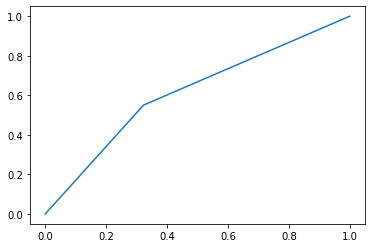

In [137]:
# sklearn에서 ROC 패키지 활용
fpr, tpr, thresholds = roc_curve(test_y,pred_y,pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

In [138]:
table_logit = logit[-10:]

In [139]:
table_logit['logit'] = pred_y[-10:]

In [140]:
ratio = results.predict_proba(test_x)[-10:] # [-1,1]

In [141]:
table_logit['up_ratio'] = 0.1
for i in range(10):
  table_logit['up_ratio'].iloc[i] = ratio[i][1] 

In [142]:
table_logit.to_csv('cell_logit_table.csv', index=False)

In [143]:
joblib.dump(results, 'logit_cell_model.pkl')

['logit_cell_model.pkl']